In [1]:
!pip install -U kaggle

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.3)


In [0]:
!mkdir ~/.kaggle

In [3]:
!ls

sample_data


In [4]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"sukhitashvili","key":"ba3102461cd69f7b9f8330d5b1e4cc4c"}'}

In [0]:
!cp kaggle.json ~/.kaggle/

In [6]:
!ls

kaggle.json  sample_data


In [7]:
!kaggle datasets download -d kmader/finding-lungs-in-ct-data

 99% 524M/529M [00:12<00:00, 24.3MB/s]
100% 529M/529M [00:12<00:00, 43.0MB/s]


In [8]:
!ls

finding-lungs-in-ct-data.zip  kaggle.json  sample_data


In [0]:
!mkdir data

In [0]:
!mv finding-lungs-in-ct-data.zip data

In [11]:
%cd data

/content/data


In [12]:
!unzip finding-lungs-in-ct-data.zip

Archive:  finding-lungs-in-ct-data.zip
  inflating: 2d_images/ID_0000_Z_0142.tif  
  inflating: 2d_images/ID_0001_Z_0146.tif  
  inflating: 2d_images/ID_0002_Z_0162.tif  
  inflating: 2d_images/ID_0003_Z_0132.tif  
  inflating: 2d_images/ID_0004_Z_0066.tif  
  inflating: 2d_images/ID_0005_Z_0066.tif  
  inflating: 2d_images/ID_0006_Z_0206.tif  
  inflating: 2d_images/ID_0007_Z_0211.tif  
  inflating: 2d_images/ID_0008_Z_0065.tif  
  inflating: 2d_images/ID_0009_Z_0114.tif  
  inflating: 2d_images/ID_0010_Z_0259.tif  
  inflating: 2d_images/ID_0011_Z_0156.tif  
  inflating: 2d_images/ID_0012_Z_0167.tif  
  inflating: 2d_images/ID_0013_Z_0047.tif  
  inflating: 2d_images/ID_0014_Z_0116.tif  
  inflating: 2d_images/ID_0015_Z_0136.tif  
  inflating: 2d_images/ID_0016_Z_0208.tif  
  inflating: 2d_images/ID_0017_Z_0061.tif  
  inflating: 2d_images/ID_0018_Z_0069.tif  
  inflating: 2d_images/ID_0019_Z_0088.tif  
  inflating: 2d_images/ID_0020_Z_0070.tif  
  inflating: 2d_images/ID_0021_Z_0066

In [13]:
!rm finding-lungs-in-ct-data.zip
!ls

2d_images  2d_masks  3d_images	lung_stats.csv


In [14]:
%cd ..

/content


In [39]:
!ls

data  kaggle.json  sample_data


### **preparer data**

In [0]:
# Prepare the Dataset

IMAGE_DIR = '2d_images'
MASK_DIR = '2d_masks'

import csv
import os

with open('data/lung_dataset.csv', 'w') as csv_file:
  
  writer = csv.writer(csv_file)
  writer.writerow(['file path', 'mask path'])
  
  for file in os.listdir('data/' + IMAGE_DIR):
    image_path = os.path.join(IMAGE_DIR, file)
    mask_path = os.path.join(MASK_DIR, file)
    writer.writerow([image_path, mask_path])  

In [19]:
import pandas as pd


df = pd.read_csv("data/lung_dataset.csv")
df.head()

,file path,mask path
0,2d_images/ID_0108_Z_0259.tif,2d_masks/ID_0108_Z_0259.tif
1,2d_images/ID_0071_Z_0072.tif,2d_masks/ID_0071_Z_0072.tif
2,2d_images/ID_0093_Z_0123.tif,2d_masks/ID_0093_Z_0123.tif
3,2d_images/ID_0246_Z_0228.tif,2d_masks/ID_0246_Z_0228.tif
4,2d_images/ID_0013_Z_0047.tif,2d_masks/ID_0013_Z_0047.tif


In [0]:
import numpy as np

data = pd.read_csv("data/lung_dataset.csv")
data = data.iloc[np.random.permutation(len(data))]
p = int(len(data)*0.7)
train, validation = data[:p], data[p:]
train.to_csv("data/lung_dataset_train.csv", index=False)
validation.to_csv("data/lung_dataset_val.csv", index=False)

### **create custom dataset**

In [0]:
from torch.utils.data import Dataset
import torchvision.transforms.functional as TF
import torchvision.transforms as transforms

import numpy as np
# from PIL import Image    #### <---PIL package did not work :(

import cv2

to_pil_image = transforms.ToPILImage()

class Lung_dataset(Dataset):
  
  def __init__(self, csv_file, root_dir = 'data'):
    """
        Args:
            csv_file (string): Path to the csv file with;
            root_dir (string): Directory with all the folders;
            transform (callable, optional): Optional transform to be applied on a sample.
    """
    self.data_frame = pd.read_csv(csv_file)
    self.root_dir = root_dir
    
  def __len__(self):
    return len(self.data_frame)
  
  def transform(self, image, mask):
    image = to_pil_image(image)
    mask = to_pil_image(mask)
    
    # Random crop
    i, j, h, w = transforms.RandomCrop.get_params(
    image, output_size=(512, 512))
    image = TF.crop(image, i, j, h, w)
    mask = TF.crop(mask, i, j, h, w)

    # Random horizontal flipping
    if np.random.random() > 0.5:
      image = TF.hflip(image)
      mask = TF.hflip(mask)

    # Random vertical flipping
    if np.random.random() > 0.5:
      image = TF.vflip(image)
      mask = TF.vflip(mask)
      
    # Random rotation
    if np.random.random() > 0.5:
      image = TF.rotate(image, 45)
      mask = TF.rotate(mask, 45)

    # Transform to tensor
    image = TF.to_tensor(image)
    mask = TF.to_tensor(mask)
    
    return image, mask
  
  def __getitem__(self, indx):
    img_path = os.path.join(self.root_dir, self.data_frame.iloc[indx, 0])
    mask_path = os.path.join(self.root_dir, self.data_frame.iloc[indx, 1])
    
    img = cv2.imread(img_path, 0)
    img = img.reshape((img.shape[0], img.shape[1], 1))
    mask = cv2.imread(mask_path, 0)
    mask = mask.reshape((mask.shape[0], mask.shape[1], 1))
    img, mask = self.transform(img, mask)
      
    return {'image': img, 'mask': mask}

In [0]:
dataset = {x: Lung_dataset(csv_file=f'data/lung_dataset_{x}.csv') for x in ['train', 'val']}

In [0]:
from torch.utils.data import DataLoader

BATCH_SIZE = 2
dataloaders = {x: DataLoader(dataset[x], 
                            batch_size=BATCH_SIZE, 
                            shuffle=True)
             for x in ['train', 'val']}

## **U-Net class**

In [0]:
# Let's implement U-net NETWORK in the following cells 

import torch
import torch.nn as nn
import torch.nn.functional as F

In [0]:
class UNetConvBlock(nn.Module):
  def __init__(self, in_size, out_size, padding, batch_norm):
    super().__init__()
    block = []
    
    block.append(nn.Conv2d(in_size, out_size, kernel_size=3, padding=int(padding)))
    if batch_norm:
      block.append(nn.BatchNorm2d(out_size))
    
    block.append(nn.ReLU())
      
    block.append(nn.Conv2d(out_size, out_size, kernel_size=3, padding=int(padding)))
    if batch_norm:
      block.append(nn.BatchNorm2d(out_size))
      
    block.append(nn.ReLU())
      
    self.block = nn.Sequential(*block)
    
  
  def forward(self, x):
    out = self.block(x)
    return out

In [0]:
class UNetUpBlock(nn.Module):
  def __init__(self, in_size, out_size, up_mode, padding, batch_norm):
    super().__init__()
    if up_mode == 'upconv':
      self.up = nn.ConvTranspose2d(in_size, out_size, kernel_size=2, stride=2)
      
    if up_mode == 'upsample':
      self.up = nn.Sequential(nn.Upsample(mode='bilinear', scale_factor=2),
                              nn.Conv2d(in_size, out_size, kernel_size=1)
                             )
    self.conv_block = UNetConvBlock(in_size, out_size, padding, batch_norm)
    
    
  def center_crop(self, layer, target_size):
    _, _, layer_height, layer_width = layer.size()
    diff_y = (layer_height - target_size[0]) // 2
    diff_x = (layer_width - target_size[1]) // 2
    
    return layer[:, :, diff_y:(diff_y + target_size[0]), diff_x:(diff_x + target_size[1])]
    
  
  def forward(self, x, bridge):
    up = self.up(x)
    crop1 = self.center_crop(bridge, up.shape[2:])
    out = torch.cat([up, crop1], 1)
    out = self.conv_block(out)
    
    return out

In [0]:
class UNet(nn.Module):
  
  def __init__(self, in_channels=1, n_classes=1, depth=5, wf=6, padding=False, batch_norm=True, up_mode='upconv'):
    """
        Implementation of
        U-Net: Convolutional Networks for Biomedical Image Segmentation
        (Ronneberger et al., 2015)
        https://arxiv.org/abs/1505.04597
        Using the default arguments will yield the exact version used
        in the original paper
        Args:
            in_channels (int): number of input channels
            n_classes (int): number of output channels
            depth (int): depth of the network
            wf (int): number of filters in the first layer is 2**wf
            padding (bool): if True, apply padding such that the input shape
                            is the same as the output.
                            This may introduce artifacts
            batch_norm (bool): Use BatchNorm after layers with an
                               activation function
            up_mode (str): one of 'upconv' or 'upsample'.
                           'upconv' will use transposed convolutions for
                           learned upsampling.
                           'upsample' will use bilinear upsampling.
    """
    super().__init__()
    assert up_mode in ('upconv', 'upsample')
    
    self.padding = padding
    self.depth = depth
    prev_channels = in_channels
    self.down_path = nn.ModuleList()
    for i in range(depth):
      self.down_path.append(UNetConvBlock(prev_channels, 2**(wf+i), padding, batch_norm))
      
      prev_channels = 2**(wf+i)
      
    self.up_path = nn.ModuleList()
    
    for i in reversed(range(depth - 1)): # use (depth-1) bcz of last Convolution layer is out of the loop
      self.up_path.append(UNetUpBlock(prev_channels, 2**(wf+i), up_mode, padding, batch_norm))
      
      prev_channels = 2**(wf+i)
    
    self.last = nn.Conv2d(prev_channels, n_classes, kernel_size=1)
    
  
  def forward(self, x):
    blocks = []
    down_path_len = len(self.down_path)
    
    for i, down in enumerate(self.down_path):
      x = down(x)
      
      if i != down_path_len - 1: # use -1 bcz of we don't need keep track of last block
        blocks.append(x)
        x = F.max_pool2d(x, 2)
    for i, up in enumerate(self.up_path):
      x = up(x, blocks[-i-1])
      
    output = self.last(x)
    
    return torch.sigmoid(output)

### **preparer for training**

In [0]:
# make function to initialize weights properly
import torch.nn.init as init

def weight_init(module):
  if isinstance(module, nn.Conv2d):
    init.xavier_normal_(module.weight)
    init.constant_(module.bias, 0.01)

In [0]:
model = UNet(in_channels=1, n_classes=1, padding=True)
model.apply(weight_init) # apply wightt init function
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# send the model to device
model = model.to(device)

In [0]:
import torch.optim as optim

optimizer = optim.Adam(model.parameters())
criterion = nn.BCELoss()

In [0]:
def test(model_instance):
  model_instance.eval()
  loss = 0
  correct = 0
  total = 0 
  with torch.set_grad_enabled(False):
    for data in dataloaders['val']:
      x = data['image'].to(device).float()
      y = data['mask'].to(device).float()
      output = model_instance(x)
      loss += criterion(output, y)
      output = torch.round(output)
      correct += (output == y).sum()
      total += output.size(0) * output.size(1) * output.size(2) * output.size(3)
    
  accuracy = 100 * correct / total
  loss = loss / len(dataloaders['val'].dataset)
  
  return accuracy, loss

In [0]:
def train(model_instance, epoch):
  # delete
  model_instance.to(device)
  model_instance.train()
  train_loss = 0
  train_correct = 0
  train_total = 0
  
  for data in dataloaders['train']:
    optimizer.zero_grad()
    x = data['image'].to(device).float()
    y = data['mask'].to(device).float()
    output = model_instance(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    
    # make info for stats
    output = torch.round(output)
    train_loss += loss
    train_correct += (output == y).sum()
    train_total += output.size(0) * output.size(1) * output.size(2) * output.size(3)
  
  
  train_accuracy = 100 * train_correct / train_total
  train_loss = train_loss / len(dataloaders['train'].dataset)
  print(f'Epoch-{epoch} <> Train Accuracy-{train_accuracy}% <> Train-Loss-{train_loss.data} <>')  
  
  test_accuracy, test_loss = test(model_instance)
  print(f'\t Epoch-{epoch} <> Test Accuracy-{test_accuracy}% <> Test-Loss-{test_loss.data} <>')

In [94]:
device

device(type='cuda', index=0)

In [95]:
# model may wont learn bcz of small size of data

for epoch in range(25):
  train(model, epoch)

Epoch-0 <> Train Accuracy-90% <> Train-Loss-0.14278045296669006 <>
	 Epoch-0 <> Test Accuracy-59% <> Test-Loss-1.0844112634658813 <>
Epoch-1 <> Train Accuracy-97% <> Train-Loss-0.054519057273864746 <>
	 Epoch-1 <> Test Accuracy-62% <> Test-Loss-1.3277676105499268 <>
Epoch-2 <> Train Accuracy-97% <> Train-Loss-0.03911503776907921 <>
	 Epoch-2 <> Test Accuracy-83% <> Test-Loss-0.21996283531188965 <>
Epoch-3 <> Train Accuracy-97% <> Train-Loss-0.03234576806426048 <>
	 Epoch-3 <> Test Accuracy-78% <> Test-Loss-0.5933124423027039 <>
Epoch-4 <> Train Accuracy-98% <> Train-Loss-0.029991690069437027 <>
	 Epoch-4 <> Test Accuracy-81% <> Test-Loss-0.35609471797943115 <>
Epoch-5 <> Train Accuracy-98% <> Train-Loss-0.026472745463252068 <>
	 Epoch-5 <> Test Accuracy-81% <> Test-Loss-0.3458276093006134 <>
Epoch-6 <> Train Accuracy-98% <> Train-Loss-0.02386413887143135 <>
	 Epoch-6 <> Test Accuracy-75% <> Test-Loss-0.6745445132255554 <>
Epoch-7 <> Train Accuracy-98% <> Train-Loss-0.02177571691572666 

## **show results**

In [0]:
import matplotlib.pyplot as plt
import numpy as np

# make 'show output' function
to_image = transforms.Compose([transforms.ToPILImage(),
                              ])

def show_image(model, image_tensor, terget_tensor, title=None):
  model.cpu()
  model.eval()
  # print original
  terget_tensor = terget_tensor.clone() # we clone the tensor to not do changes on it
  image = to_image(terget_tensor)
  plt.imshow(np.asarray(image))
  if title is not None:
    plt.title('Original ' + title)
  plt.pause(0.001) # pause a bit so that plots are updated
 
  # print prediction
  output = model(image_tensor.unsqueeze(0)) # add fake batch dimension
  output = torch.round(output.squeeze(0))   # remove fake batch dimension
  image = to_image(output)
  plt.imshow(np.asarray(image))
  if title is not None:
    plt.title('Predicted ' + title)
  plt.pause(0.001) # pause a bit so that plots are updated

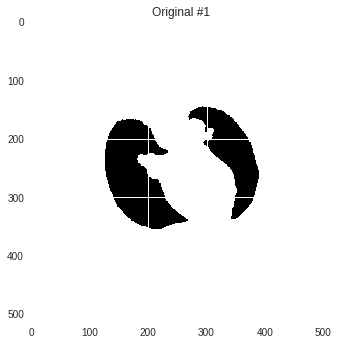

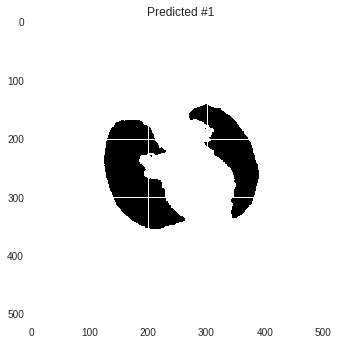

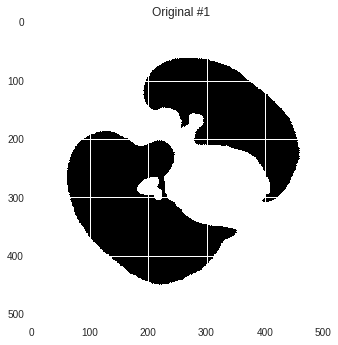

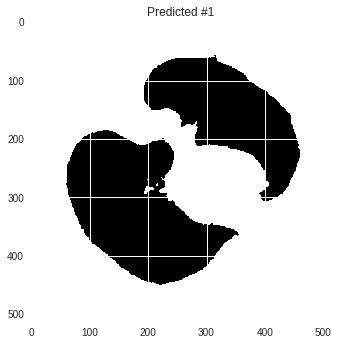

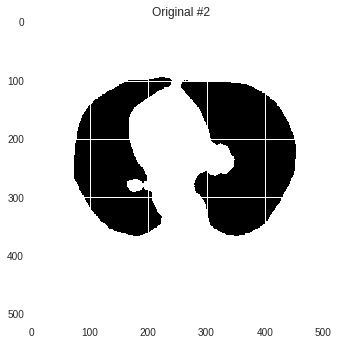

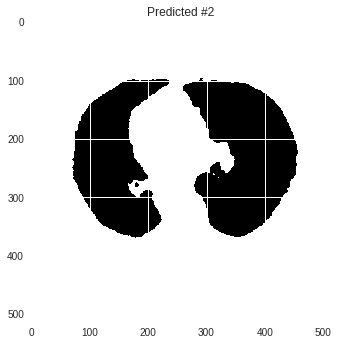

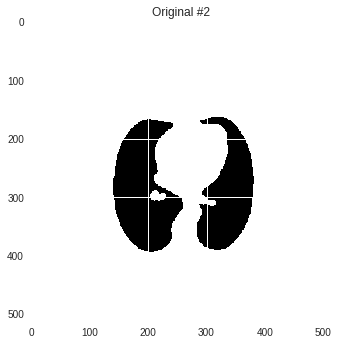

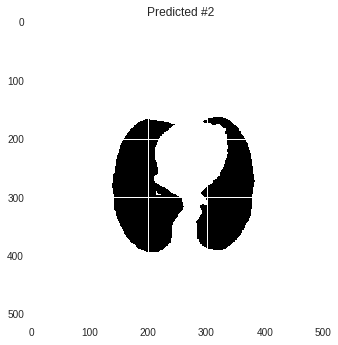

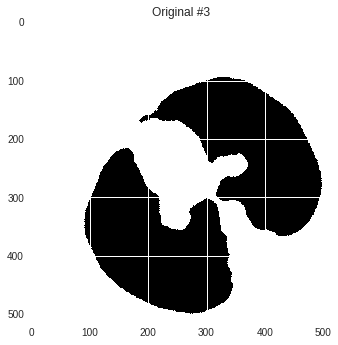

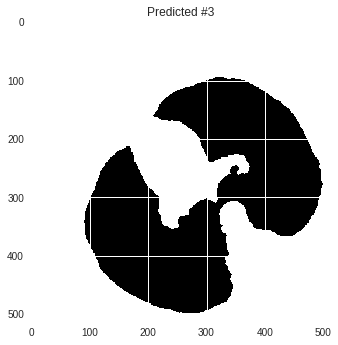

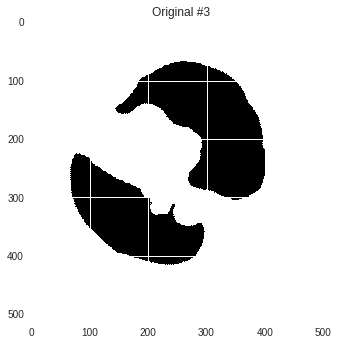

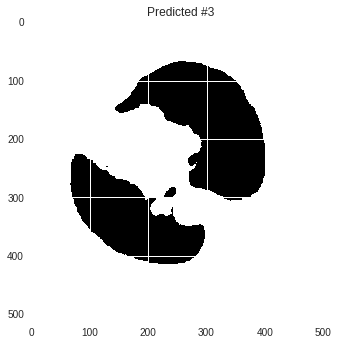

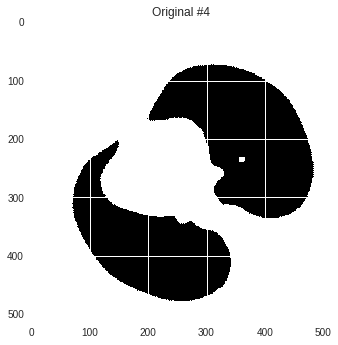

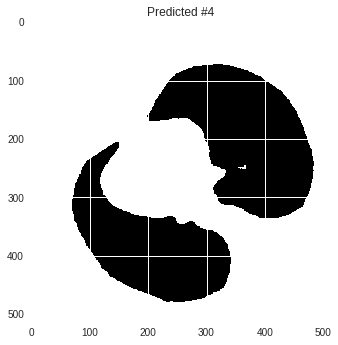

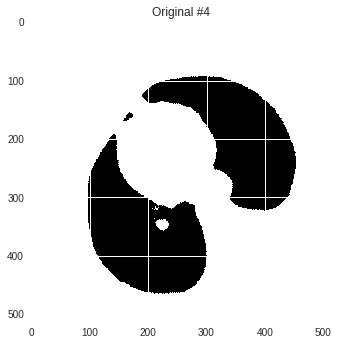

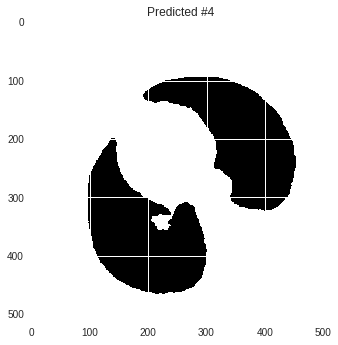

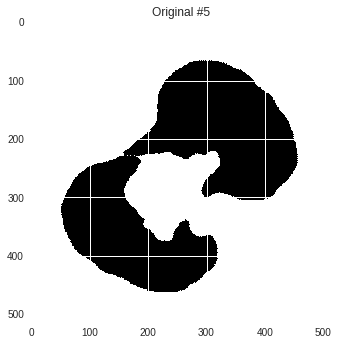

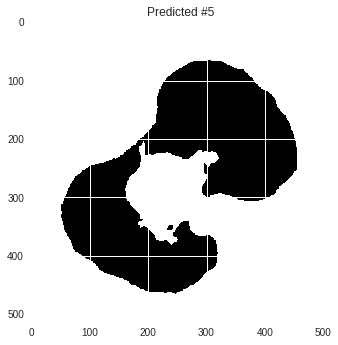

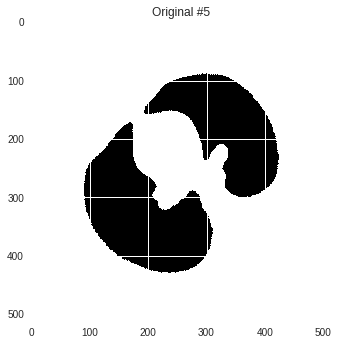

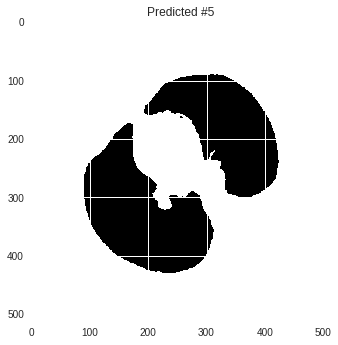

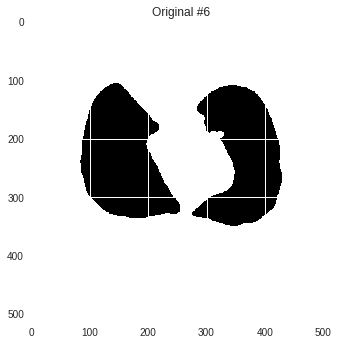

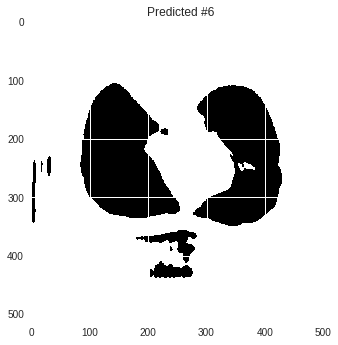

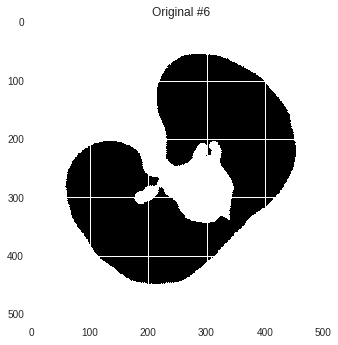

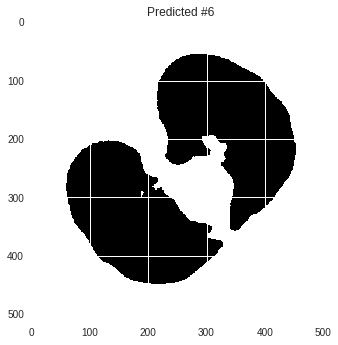

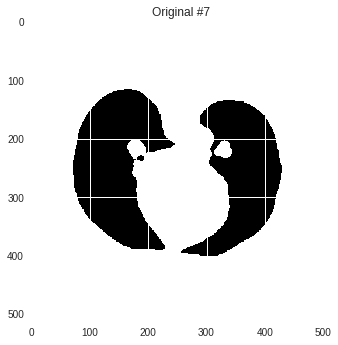

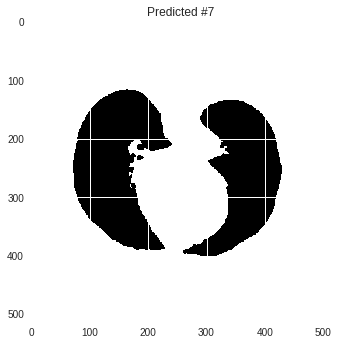

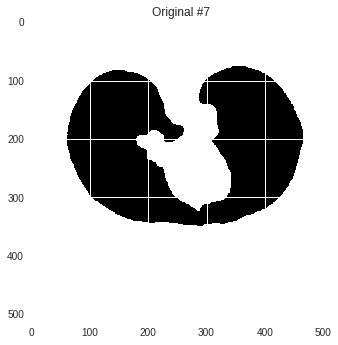

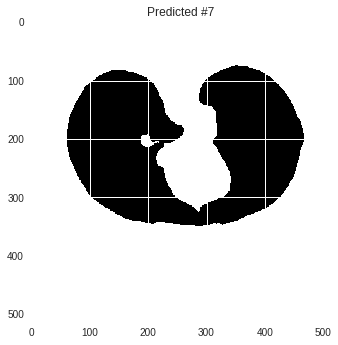

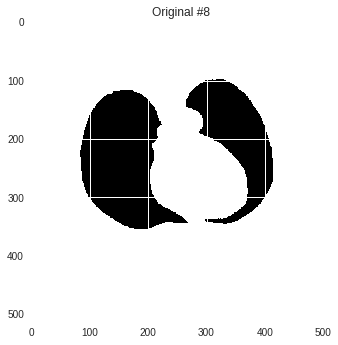

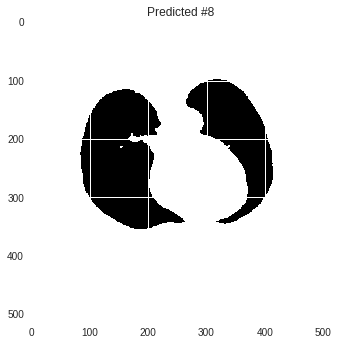

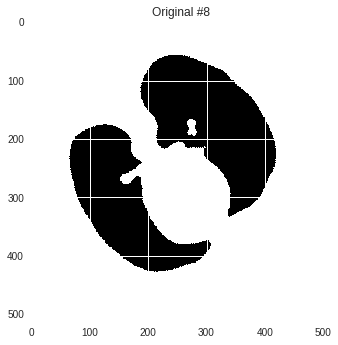

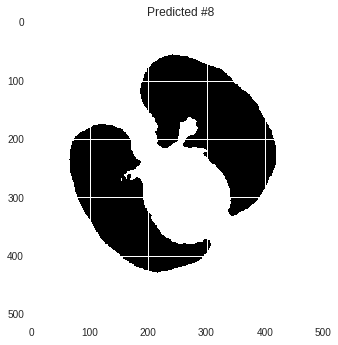

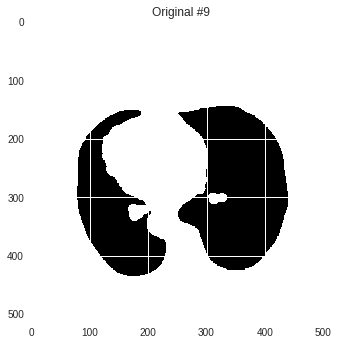

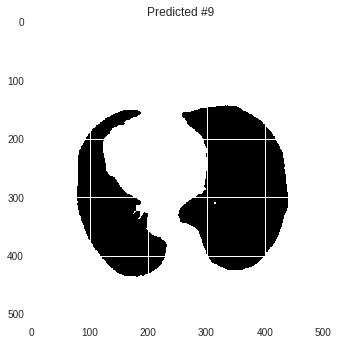

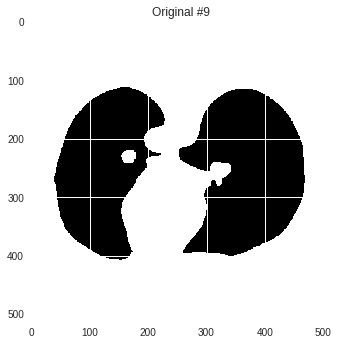

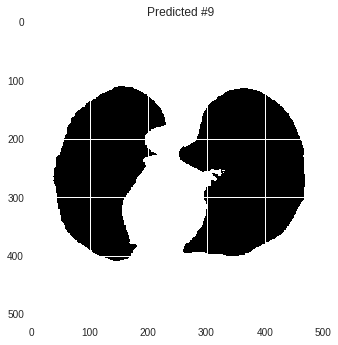

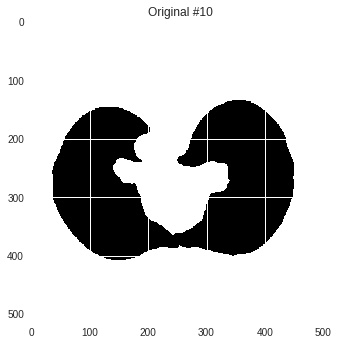

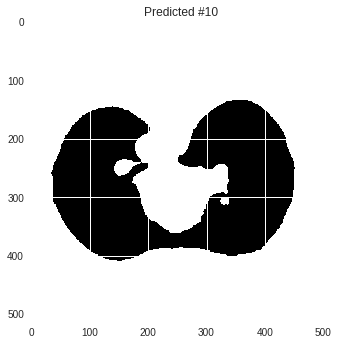

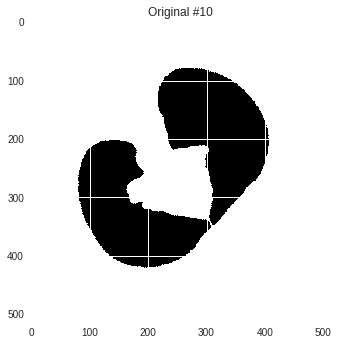

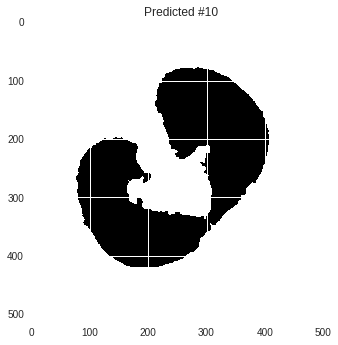

In [100]:
show_items = 10
iter_ = 0
for data in dataloaders['val']:
  image_tensor = data['image'].float()
  mask_tensor = data['mask'].float()
  
  if iter_ == show_items:
    break
    
  iter_ += 1
  for batch in range(BATCH_SIZE):
    show_image(model, image_tensor[batch, :, :, :], mask_tensor[batch, :, :, :], title=f'#{iter_}')